<a href="https://colab.research.google.com/github/goerlitz/nlp-classification/blob/main/notebooks/10kGNAD/colab/21f_10kGNAD_huggingface_fit_1_cycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adoption of fit 1 cycle from FastAI for Tranformer Model

## Prerequisites

In [1]:
checkpoint = "distilbert-base-german-cased"
# checkpoint = "deepset/gbert-base"
# checkpoint = "deepset/gelectra-base"

# project_name = f'10kgnad_hf__{checkpoint.replace("/", "_")}'

### Connect Google Drive

Will be used to save results

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
# from pathlib import Path

# # define model path
# root_path = Path('/content/gdrive/My Drive/')
# base_path = root_path / 'Colab Notebooks/nlp-classification/'
# model_path = base_path / 'models'

## Check GPU

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jan  5 22:21:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    43W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install Packages

In [5]:
%%time
!pip install -q -U transformers datasets >/dev/null

# check installed version
!pip freeze | grep transformers  # transformers==4.15.0
!pip freeze | grep "torch "      # torch==1.10.0+cu111

transformers==4.15.0
torch @ https://download.pytorch.org/whl/cu111/torch-1.10.0%2Bcu111-cp37-cp37m-linux_x86_64.whl
CPU times: user 39.9 ms, sys: 18.4 ms, total: 58.4 ms
Wall time: 4.35 s


In [6]:
from transformers import logging

# hide progress bar when downloading tokenizer and model (a workaround!)
logging.get_verbosity = lambda : logging.NOTSET

## Load Dataset

In [7]:
from datasets import load_dataset

gnad10k = load_dataset("gnad10")
label_names = gnad10k["train"].features["label"].names

Using custom data configuration default
Reusing dataset gnad10 (/root/.cache/huggingface/datasets/gnad10/default/1.1.0/3a8445be65795ad88270af4d797034c3d99f70f8352ca658c586faf1cf960881)


  0%|          | 0/2 [00:00<?, ?it/s]

## Data Preprocessing

* Loading the same Tokenizer that was used with the pretrained model.
* Define function to tokenize the text (with truncation to max input length of model.
* Run the tokenization

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_data = gnad10k.map(preprocess_function, batched=True).remove_columns("text")

Loading cached processed dataset at /root/.cache/huggingface/datasets/gnad10/default/1.1.0/3a8445be65795ad88270af4d797034c3d99f70f8352ca658c586faf1cf960881/cache-5d66d7a004b32c63.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/gnad10/default/1.1.0/3a8445be65795ad88270af4d797034c3d99f70f8352ca658c586faf1cf960881/cache-1e7aaca04dbb52e2.arrow


### Use Dynamic Padding

Apply panding only on longest text in batch - this is more efficient than applying padding on the whole dataset.

In [9]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Model Setup

We want to include the label names and save them together with the model.
The only way to do this is to create a Config and put them in. 

In [21]:
from transformers import AutoConfig, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, matthews_corrcoef

epochs = 1
bs = 32
lr = 1e-4

eval_rounds_per_epoch = 5
eval_steps = gnad10k["train"].num_rows / bs // eval_rounds_per_epoch

def model_init():
    """A function that instantiates the model to be used."""

    config = AutoConfig.from_pretrained(
        checkpoint,
        num_labels=len(label_names),
        id2label={i: label for i, label in enumerate(label_names)},
        label2id={label: i for i, label in enumerate(label_names)},
        )

    return AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)

model = model_init()

def compute_metrics(eval_preds):
    """The function that will be used to compute metrics at evaluation.
    Must take a :class:`~transformers.EvalPrediction` and return a dictionary
    string to metric values."""
    logits, labels = eval_preds
    preds = np.argmax(logits, axis=-1)
    return {
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro'),
        "precision": precision_score(labels, preds, average='macro'),
        "recall": recall_score(labels, preds, average='macro'),
        "mcc": matthews_corrcoef(labels, preds),
        }

# https://github.com/huggingface/transformers/blob/v4.15.0/src/transformers/training_args.py#L73
training_args = TrainingArguments(
    output_dir="/tmp",
    report_to=[],
    log_level="error",
    disable_tqdm=False,

    logging_steps=1,  # log train loss in every step
    # gradient_accumulation_steps=gradient_accumulation_steps,
    evaluation_strategy="steps",
    eval_steps=eval_steps,

    # hyperparameters
    num_train_epochs=epochs,
    learning_rate=lr,
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs,
    # weight_decay=weight_decay,
    # warmup_ratio=0.5,
)

# https://github.com/huggingface/transformers/blob/master/src/transformers/trainer.py
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    # optimizers=(optimizer, lr_scheduler)
)

In [22]:
trainer.train()

Step,Training Loss,Validation Loss,Acc,F1,Precision,Recall,Mcc
57,0.480700,0.562641,0.837549,0.837573,0.846689,0.841097,0.816433
114,0.658200,0.487643,0.851167,0.846432,0.861474,0.842092,0.830202
171,0.418100,0.444330,0.864786,0.862721,0.868550,0.858943,0.845028
228,0.425300,0.399229,0.868677,0.868927,0.866012,0.875843,0.850407
285,0.366400,0.384068,0.876459,0.877303,0.879674,0.876932,0.858723


TrainOutput(global_step=289, training_loss=0.6030490607487289, metrics={'train_runtime': 298.3593, 'train_samples_per_second': 30.986, 'train_steps_per_second': 0.969, 'total_flos': 1224813981219840.0, 'train_loss': 0.6030490607487289, 'epoch': 1.0})

In [23]:
import pandas as pd

# get train loss and learning rate
train_loss = pd.DataFrame([i for i in trainer.state.log_history[:-1] if "learning_rate" in i]).set_index("step")
# train_loss

In [24]:
# get validation loss
val_loss = pd.DataFrame([i for i in trainer.state.log_history[:-1] if "eval_loss" in i]).set_index("step")
# val_loss

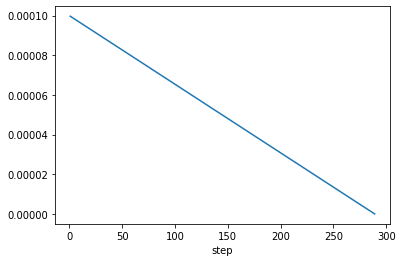

In [25]:
train_loss.learning_rate.plot();

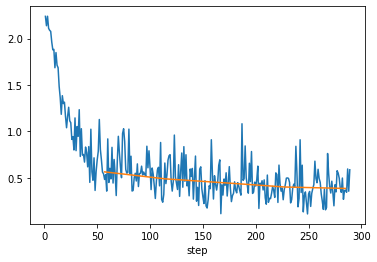

In [26]:
train_loss.loss.plot()
val_loss.eval_loss.plot();

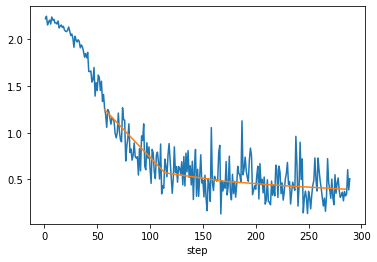

In [16]:
train_loss.loss.plot()
val_loss.eval_loss.plot();